In [3]:
import os
import urllib.request
from urllib.error import HTTPError

import lightning as L
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from torchmetrics import Accuracy

import pandas as pd
import seaborn as sn
import matplotlib
import matplotlib.pyplot as plt

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/VisionTransformers/")
BATCH_SIZE = 256 if torch.cuda.is_available() else 64

L.seed_everything(42)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device: ", device)

Global seed set to 42


Device:  cuda:0


Global seed set to 42
Global seed set to 42


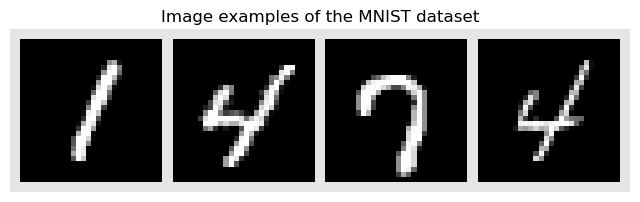

In [4]:
test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop((28, 28), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

train_dataset = MNIST(root=PATH_DATASETS, train=True, transform=train_transform, download=True)
val_dataset = MNIST(root=PATH_DATASETS, train=True, transform=test_transform, download=True)
L.seed_everything(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [55000, 5000])
L.seed_everything(42)
_, val_set = torch.utils.data.random_split(val_dataset, [55000, 5000])

test_set = MNIST(root=PATH_DATASETS, train=False, transform=test_transform, download=True)

train_loader = data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=4)

NUM_IMAGES = 4
MNIST_images = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(MNIST_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Image examples of the MNIST dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

In [5]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W]
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W]
    return x

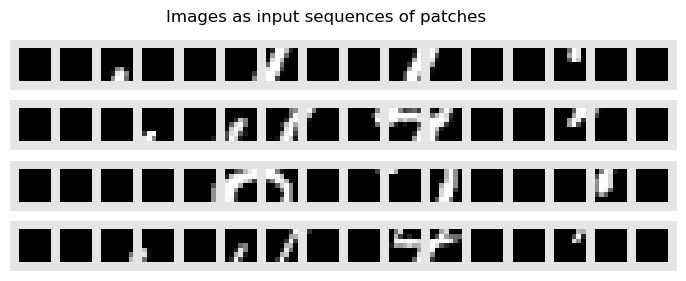

In [6]:
img_patches = img_to_patch(MNIST_images, patch_size=7, flatten_channels=False)

fig, ax = plt.subplots(MNIST_images.shape[0], 1, figsize=(14, 3))
fig.suptitle("Images as input sequences of patches")
for i in range(MNIST_images.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis("off")
plt.show()
plt.close()

In [7]:
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

In [8]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        embed_dim,
        hidden_dim,
        num_channels,
        num_heads,
        num_layers,
        num_classes,
        patch_size,
        num_patches,
        dropout=0.0,
    ):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        self.patch_size = patch_size

        self.input_layer = nn.Linear(num_channels * (patch_size**2), embed_dim)
        self.transformer = nn.Sequential(
            *(AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers))
        )
        self.mlp_head = nn.Sequential(nn.LayerNorm(embed_dim), nn.Linear(embed_dim, num_classes))
        self.dropout = nn.Dropout(dropout)

        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))

    def forward(self, x):
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embedding[:, : T + 1]

        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)

        cls = x[0]
        out = self.mlp_head(cls)
        return out

In [9]:
class ViT(L.LightningModule):
    def __init__(self, model_kwargs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = VisionTransformer(**model_kwargs)
        self.example_input_array = next(iter(train_loader))[0]

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)
        lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log("%s_loss" % mode, loss)
        self.log("%s_acc" % mode, acc)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

In [12]:
def train_model(**kwargs):
    trainer = L.Trainer(
        callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=5)],
        default_root_dir=os.path.join(CHECKPOINT_PATH, "ViT"),
        accelerator="auto",
        devices=1,
        max_epochs=180,
        logger=CSVLogger(save_dir="logs/")
    )
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ViT.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model at %s, loading..." % pretrained_filename)
        model = ViT.load_from_checkpoint(pretrained_filename)
    else:
        L.seed_everything(42)
        model = ViT(**kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = ViT.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    val_result = trainer.test(model, dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}
    
    metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
    del metrics["step"]
    metrics.set_index("epoch", inplace=True)
    display(metrics.dropna(axis=1, how="all").head())
    sn.relplot(data=metrics, kind="line")

    return model, result

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | In sizes         | Out sizes
---------------------------------------------------------------------------
0 | model | VisionTransformer | 3.2 M  | [256, 1, 28, 28] | [256, 10]
---------------------------------------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.732    Total estimated model par

Epoch 31: 100%|██████████| 214/214 [00:27<00:00,  7.81it/s, v_num=15]      


You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 27.14it/s]


You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 56.26it/s]


,train_loss,train_acc,val_loss,val_acc,test_loss,test_acc
epoch,,,,,,
0,0.881131,0.707031,NaN,NaN,NaN,NaN
0,0.693956,0.765625,NaN,NaN,NaN,NaN
0,0.467941,0.839844,NaN,NaN,NaN,NaN
0,0.372919,0.867188,NaN,NaN,NaN,NaN
0,NaN,NaN,0.322758,0.9,NaN,NaN


ViT results {'test': 0.980400025844574, 'val': 0.9818000197410583}


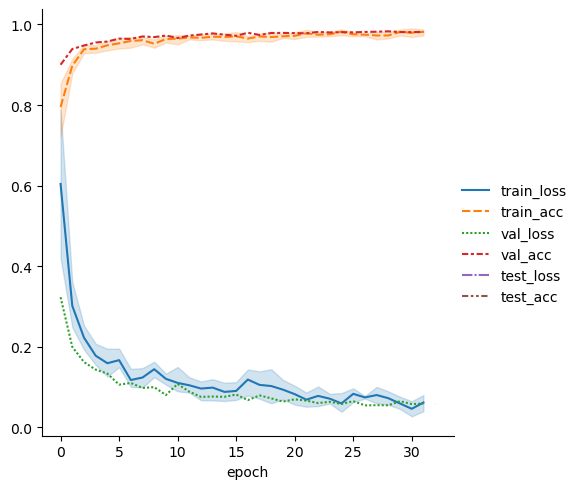

In [13]:
model, results = train_model(
    model_kwargs={
        "embed_dim": 256,
        "hidden_dim": 512,
        "num_heads": 8,
        "num_layers": 6,
        "patch_size": 7,
        "num_channels": 1,
        "num_patches": 16,
        "num_classes": 10,
        "dropout": 0.2,
    },
    lr=3e-4,
)
print("ViT results", results)